In [1]:
import sys
import pathlib
pth=str(pathlib.Path().absolute())
sys.path.append(('\\').join(pth.split('\\')[:-1])+"\\Utils")
from Utilities import *
from MF import *
from Visualization_utilities import *
from transformation import Transformation
from Signatures import Signature
#import seaborn as sns
#import pandas as pd

In [53]:
def project_pcl(pcl):
    pcl.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamKNN(30))
    pcl, ind = pcl.remove_statistical_outlier(nb_neighbors=5,std_ratio=1.5)
    pcl=pcl.voxel_down_sample(voxel_size=0.02)
    pcl.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamKNN(30))
   
    indexes=np.arange(np.asarray(pcl.points).shape[0])
    pt = o3d.geometry.KDTreeFlann(pcl)
    signatures=Signature(pcl,pt,indexes)
    Signature().v_build(signatures,NN_Criteria="KNN",
                    rad=np.std(np.asarray(pcl.points)-np.mean(np.asarray(pcl.points),axis=0))/8,
                   NN=30)

    signaturesp=remove_discontinuities_by_curvature(pcl,signatures,pt,curvature=0.4,radius=0.5)
    pp=prune_points(signaturesp,"sphericity",0.5)
    points=np.vectorize(lambda x: x.pointCoordinates,signature="()->(j)")(pp)
    pts=o3d.geometry.PointCloud()
    pts.points=o3d.utility.Vector3dVector(points)

    obb=pts.get_oriented_bounding_box()
    dpp=copy.deepcopy(pcl)
    dpp.rotate(obb.R)
    pa=np.asarray(dpp.points)
    pa[:,0]=0
    pts.points=o3d.utility.Vector3dVector(pa)
    return pts

In [3]:
# Ejemplo de aplicación
pts='A1_MODELO_3D_revA_L5x3x1_400_pulg_001.pts'
dpf=o3d.io.read_point_cloud("E:\\INNOVATE\\Aceptado\\"+pts)
pts=project_pcl(dpf)
o3d.visualization.draw_geometries([pts])

In [ ]:

#Carga de nubes
dp=Geometry_load(path="E:\\INNOVATE\\Aceptado\\"+pts,
                    visualization=True,
                    voxel_down_sample=0.02,
                    geometry_type="pointCloud")

In [56]:
#Construcción de signatures
indexes=np.arange(np.asarray(dp.points).shape[0])
pt = o3d.geometry.KDTreeFlann(dp)
signatures=Signature(dp,pt,indexes)
Signature().v_build(signatures,NN_Criteria="KNN",
                    rad=np.std(np.asarray(dp.points)-np.mean(np.asarray(dp.points),axis=0))/8,
                   NN=30)

array([None, None, None, ..., None, None, None], dtype=object)

In [30]:
sig=signatures.tolist()
sig.sort(key=lambda x: getattr(x,'sphericity'), reverse=True)

In [57]:
#Filtro de discontinuidades
signaturesp=remove_discontinuities_by_curvature(dp,signatures,pt,curvature=0.4,radius=0.5)
print(signatures.shape)
print(signaturesp.shape)
graficarPropiedad(signaturesp,dp,property="sphericity",frac=1)

(1941,)
(1542,)


In [32]:
graficarPropiedad(signaturesp,dp,property="sphericity",frac=0.2)

In [58]:
#Filtro de partes planas
print(np.asarray(dp.points).shape)
#signaturesp=remove_discontinuities_by_curvature(dp,signatures,pt,curvature=0.4,radius=0.02)
print("Total points")
print(len(signatures))
print("Non discontinuitinual points")
print(len(signaturesp))
pp=prune_points(signaturesp,"sphericity",0.5)
pp=np.array(pp)
print("Pruned points")
print(len(pp))
rat=0.1
ppp=random_sample(pp,rat)
ppp=np.array(ppp)
print("numero de puntos aleatorios")
print(len(ppp))

(1941, 3)
Total points
1941
Non discontinuitinual points
1542
Pruned points
76
numero de puntos aleatorios
7


In [59]:
#Estracción de puntos filtrados
points=np.vectorize(lambda x: x.pointCoordinates,signature="()->(j)")(pp)
pts=o3d.geometry.PointCloud()
pts.points=o3d.utility.Vector3dVector(points)
o3d.visualization.draw_geometries([pts])

In [60]:
#Determinación de bounding box
obb=pts.get_oriented_bounding_box()
mesh=o3d.geometry.TriangleMesh.create_coordinate_frame(size=80.0, origin=pts.get_center())
mesh.rotate(obb.R)
o3d.visualization.draw_geometries([pts,mesh])

In [36]:
o3d.visualization.draw_geometries([dp.rotate(obb.R),mesh])

In [37]:
#Proyección
pa=np.asarray(dp.points)
pa[:,1]=0
pts.points=o3d.utility.Vector3dVector(pa)
o3d.visualization.draw_geometries([pts])

In [39]:
indexes=np.arange(np.asarray(dp.points).shape[0])
pt = o3d.geometry.KDTreeFlann(dp)
signatures=Signature(dp,pt,indexes)
Signature().v_build(signatures,NN_Criteria="KNN",
                    rad=np.std(np.asarray(dp.points)-np.mean(np.asarray(dp.points),axis=0))/8,
                   NN=30)

signaturesp=remove_discontinuities_by_curvature(dp,signatures,pt,curvature=0.4,radius=0.5)
pp=prune_points(signaturesp,"sphericity",0.5)
points=np.vectorize(lambda x: x.pointCoordinates,signature="()->(j)")(pp)
pts=o3d.geometry.PointCloud()
pts.points=o3d.utility.Vector3dVector(points)

obb=pts.get_oriented_bounding_box()
dpp=copy.deepcopy(dp)
dpp.rotate(obb.R)
pa=np.asarray(dpp.points)
pa[:,1]=0
pts.points=o3d.utility.Vector3dVector(pa)
o3d.visualization.draw_geometries([pts])



In [9]:
[trans_s,rs,KDT,query]=build_pairing_kd_tree(dp,pp,rad=100000.6,rand_samp_percentage=rat,
                                             rigid=True,only_reflections=True,NN=80)

In [10]:
trans_space=trans_s[:,0]
np_points=Transformation().v_toPoint(trans_space)

In [11]:

df = pd.DataFrame(np_points, columns = ['k','Rx','Ry','Rz','Tx','Ty','Tz'])
df

,k,Rx,Ry,Rz,Tx,Ty,Tz
0,0.01,0.011109,-0.028464,-0.316840,0.017155,-0.003001,0.000871
1,0.01,-0.037437,-0.085448,-0.299471,0.016810,-0.003380,-0.001137
2,0.01,-0.037894,0.014538,-0.006188,-0.000043,0.000204,0.000652
3,0.01,-0.004482,0.002634,0.314485,0.016162,-0.004671,-0.001818
4,0.01,-0.036677,-0.077577,-0.304256,0.016783,-0.003499,-0.001130
...,...,...,...,...,...,...,...
33491,0.01,0.000734,0.000139,-0.000009,0.015913,0.002783,-0.000181
33492,0.01,-0.002703,-0.000306,-0.000111,0.016814,0.002031,0.000655
33493,0.01,-0.024864,-0.075049,0.091619,0.004940,-0.007284,-0.004526
33494,0.01,-0.013408,-0.002515,-0.317813,0.015868,0.002759,-0.000211


C:\Users\grmc1\Anaconda3\envs\INNOVATE\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

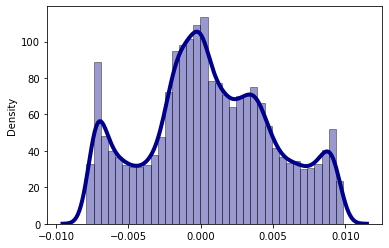

In [12]:
sns.distplot(np_points[:,6], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

C:\Users\grmc1\Anaconda3\envs\INNOVATE\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

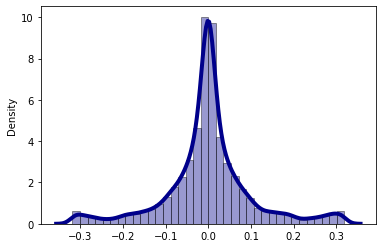

In [13]:
sns.distplot(np_points[:,1], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

C:\Users\grmc1\Anaconda3\envs\INNOVATE\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

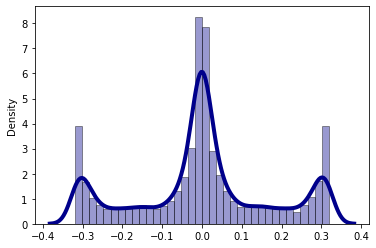

In [14]:
sns.distplot(np_points[:,3], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

C:\Users\grmc1\Anaconda3\envs\INNOVATE\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


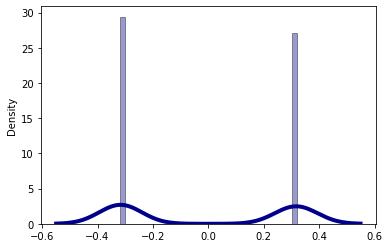

In [15]:
pTrans=pruneTransPoints(trans_s=trans_s[:,0],
                #Rx_th=0.001*math.pi/(math.pi**2),
                #Ry_th=0.001*math.pi/(math.pi**2),
                Rz_th_min=0*math.pi/(math.pi**2),
                Rz_th_max=0.99*math.pi/(math.pi**2),
                #Tz_th=0.001/(4/((diagonal_length)**2)),
                #Ty_th=0.0001/(4/((diagonal_length)**2))
                )
np_points=Transformation().v_toPoint(pTrans)
sns.distplot(np_points[:,3], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
diagonal_length=np.linalg.norm(dp.get_max_bound()-dp.get_min_bound())
con=np.abs(np_points[:,6])<0.002
pTrans=pTrans[np.where(con)]
np_points=Transformation().v_toPoint(pTrans)

In [16]:
np_points=Transformation().v_toPoint(pTrans)

C:\Users\grmc1\Anaconda3\envs\INNOVATE\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

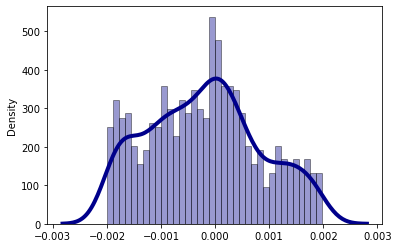

In [17]:
sns.distplot(np_points[:,6], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

In [18]:
sigp=get_signatures_from_transformation(signatures,pTrans)
points=get_cluster_points_index_from_signatures(sigp)
points.shape
pdp = o3d.geometry.PointCloud()
pdp.points = o3d.utility.Vector3dVector(np.asarray(dp.points)[points])
o3d.visualization.draw_geometries([pdp])